In [2]:
import os
os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:
- сохраненные маски для картинок из valid в формате pred_valid_template.csv (в архиве с `data`);
- html страницу с предсказанием модели для всех картинок из test и папку с используемыми картинками в этой html странице для её просмотра.

Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (в jupyter ноутбуке) с описанием Вашего исследования, предобработки, постобработки, проверямых гипотез, используемых моделей, описание лучшего подхода и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

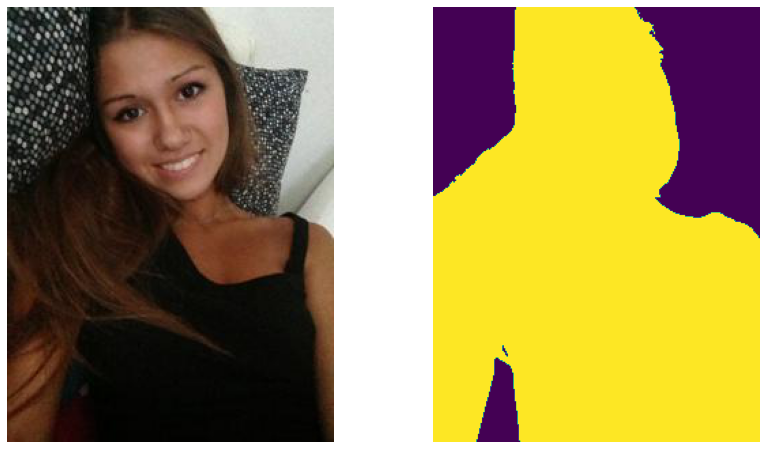

In [3]:
path = "data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [6]:
mask, random_mask

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 array([[0, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 1, 0, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]]))

In [5]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.6017827529021552

Можно для последовательности масок вычислить среднее значение метрики:

In [5]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.49915776308817544

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [6]:
rle_mask = encode_rle(mask)
rle_mask

'11167 9 11406 12 11646 14 11885 21 12124 23 12363 25 12602 26 12841 27 13080 28 13320 28 13559 28 13799 27 14038 29 14277 31 14517 32 14757 32 14996 33 15236 34 15476 34 15716 34 15955 34 16194 35 16434 35 16673 36 16913 35 17153 35 17392 36 17632 36 17871 37 18110 38 18349 39 18589 39 18829 38 19069 38 19309 39 19548 40 19786 42 20023 45 20260 48 20497 51 20735 54 20975 54 21214 55 21454 55 21694 56 21933 57 22173 57 22413 58 22653 58 22892 59 23132 59 23372 60 23612 61 23852 61 24092 60 24332 58 24572 56 24812 57 25052 57 25292 57 25532 58 25772 57 26012 57 26252 57 26492 56 26732 56 26972 56 27212 56 27452 56 27692 56 27932 55 28172 55 28412 55 28652 55 28892 55 29132 55 29372 55 29612 55 29852 54 30093 53 30332 54 30572 54 30812 54 31052 54 31292 54 31532 55 31772 55 32012 55 32251 56 32491 56 32731 56 32971 56 33211 10 33224 43 33451 9 33463 44 33691 9 33703 44 33931 9 33943 44 34171 9 34182 45 34411 9 34422 45 34651 9 34661 46 34891 8 34901 47 35131 8 35141 47 35371 8 35381 47 3

Теперь восстановим маску:

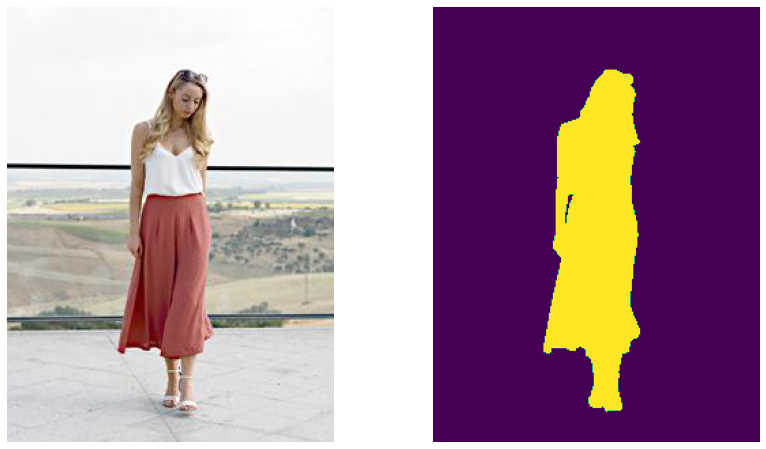

In [7]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [8]:
pred = pd.read_csv("data/pred_valid_template.csv")
pred.head()

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [9]:
paths_to_imgs = sorted(glob("data/valid/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/valid_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.